# Ensemble Model for 30-Day Loan Repayment Prediction

This notebook builds an ensemble model to predict which users will pay back their loan within 30 days.

**Objective:** Predict `repaid_full_30d` (binary target)

**Evaluation Metric:** ROC-AUC

**Models:**
- Logistic Regression (Baseline)
- Random Forest
- XGBoost
- Ensemble (Voting/Stacking)

In [ ]:
!pip install --upgrade numpy pandas scikit-learn xgboost matplotlib seaborn shap lime

  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Data

Loading the output from the previous analysis notebook.

In [ ]:
import os
print(os.getcwd())


/content


In [ ]:
# Load the preprocessed data from the analysis notebook
df = pd.read_csv('/content/mg_with_cum_balance_risk.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nTarget distribution:")
print(df['repaid_full_30d'].value_counts(normalize=True))
print(f"\nMissing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Dataset shape: (14491, 29)

Columns: ['request_id', 'underwritten_at', 'disbursed_at', 'amount', 'user_id', 'total_loan_per_user', 'advance_id', 'repaid_full_30d', 'repaid_pct_30d', 'days_to_first_repay', 'days_to_first_repay_decoded', 'Usr_Profile', 'txn_count', 'txn_total', 'txn_avg', 'top_primary_category', 'top_primary_spend', 'top_detailed_category', 'top_detailed_spend', 'top_merchant_name', 'top_merchant_spend', 'primary_ratio', 'detailed_ratio', 'merchant_ratio', 'updated_at', 'cum_avail_balance', 'cum_balance_to_loan_ratio', 'Risk', 'Risk_encoded']

Target distribution:
repaid_full_30d
True     0.747729
False    0.252271
Name: proportion, dtype: float64

Missing values:
advance_id                      292
repaid_full_30d                 292
repaid_pct_30d                  292
days_to_first_repay             546
days_to_first_repay_decoded     546
Usr_Profile                     292
txn_count                      6607
txn_total                      6607
txn_avg                 

In [ ]:
# #convert to binary
# df['Usr_Profile'] = df['Usr_Profile'].replace({
#     'good': 1, 'bad': 0,
#     'Good': 1, 'Bad': 0,
#     'GOOD': 1, 'BAD': 0
# })
# df['Usr_Profile'] = df['Usr_Profile'].fillna(0).astype(int)

# df['repay_speed_ratio'] = df['repaid_pct_30d'] / df['days_to_first_repay']


# # Strong correlation feature, can be used to predict repayment of future loans
# # If repaid_pct_30d >= 1.0 → repaid_full_30d = True (good)
# # If repaid_pct_30d < 1.0 → repaid_full_30d = False (bad)



## 2. Data Preparation

In [ ]:
feature_cols = [
    # Loan characteristics
    'amount',
    'total_loan_per_user',

    # Transaction patterns (BEFORE loan)
    'txn_count',
    'txn_total',
    'txn_avg',

    # Spending patterns (BEFORE loan)
    'top_primary_spend',
    'top_detailed_spend',
    'top_merchant_spend',
    'primary_ratio',
    'detailed_ratio',
    'merchant_ratio',

    # Balance information (BEFORE loan)
    'cum_avail_balance',
    'cum_balance_to_loan_ratio',

    # Risk assessment (BEFORE loan)
    'Risk_encoded',


]

# Create X and y
X = df[feature_cols].copy()
y = df['repaid_full_30d'].copy()

# First, remove rows where target is missing
valid_idx = y.notna()
X = X[valid_idx]
y = y[valid_idx]

# Convert target to binary (1 for True, 0 for False)
y = y.replace({True: 1, False: 0, 'TRUE': 1, 'FALSE': 0, 'True': 1, 'False': 0})
y = y.astype(int)

# Handle infinite and missing values in features
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Final feature set shape: {X.shape}")
print(f"Final target shape: {y.shape}")
print(f"\nTarget class balance:")
print(y.value_counts(normalize=True))
print(f"\nInfinite values check: {np.isinf(X).sum().sum()}")
print(f"Missing values check: {X.isna().sum().sum()}")

Final feature set shape: (14199, 14)
Final target shape: (14199,)

Target class balance:
repaid_full_30d
1    0.747729
0    0.252271
Name: proportion, dtype: float64

Infinite values check: 0
Missing values check: 0


## 3. Train-Test Split

In [ ]:
# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTrain target distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest target distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 11359 (80.0%)
Test set size: 2840 (20.0%)

Train target distribution:
repaid_full_30d
1    0.747689
0    0.252311
Name: proportion, dtype: float64

Test target distribution:
repaid_full_30d
1    0.747887
0    0.252113
Name: proportion, dtype: float64


## 4. Feature Scaling

Scaling features for logistic regression (tree-based models don't require scaling)

In [ ]:
# Handle infinite values before scaling
# Replace inf and -inf with NaN, then fill with column median
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill any remaining NaN values with median
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully")
print(f"\nScaled training data shape: {X_train_scaled_df.shape}")
print(f"\nChecking for any remaining inf/nan values:")
print(f"Training set - inf: {np.isinf(X_train_scaled_df).sum().sum()}, nan: {X_train_scaled_df.isna().sum().sum()}")
print(f"Test set - inf: {np.isinf(X_test_scaled_df).sum().sum()}, nan: {X_test_scaled_df.isna().sum().sum()}")

Features scaled successfully

Scaled training data shape: (11359, 14)

Checking for any remaining inf/nan values:
Training set - inf: 0, nan: 0
Test set - inf: 0, nan: 0


## 5. Baseline Model: Logistic Regression

In [ ]:
# Train baseline logistic regression
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled_df, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled_df)
lr_pred_proba = lr_model.predict_proba(X_test_scaled_df)[:, 1]

# Evaluate
lr_auc = roc_auc_score(y_test, lr_pred_proba)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

print("=" * 60)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("=" * 60)
print(f"ROC-AUC Score: {lr_auc:.4f}")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")

# Cross-validation
cv_scores = cross_val_score(lr_model, X_train_scaled_df, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-Validation ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

BASELINE MODEL: LOGISTIC REGRESSION
ROC-AUC Score: 0.8799
Accuracy: 0.8127
Precision: 0.9721
Recall: 0.7717
F1-Score: 0.8604

Cross-Validation ROC-AUC: 0.8760 (+/- 0.0038)


## 6. Random Forest Classifier

In [ ]:
# Train Random Forest (using unscaled data as trees don't require scaling)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
rf_auc = roc_auc_score(y_test, rf_pred_proba)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

print("=" * 60)
print("RANDOM FOREST CLASSIFIER")
print("=" * 60)
print(f"ROC-AUC Score: {rf_auc:.4f}")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

RANDOM FOREST CLASSIFIER
ROC-AUC Score: 0.8827
Accuracy: 0.8324
Precision: 0.9655
Recall: 0.8046
F1-Score: 0.8778

Top 10 Most Important Features:
                      feature  importance
1         total_loan_per_user    0.687214
11          cum_avail_balance    0.065502
12  cum_balance_to_loan_ratio    0.059327
7          top_merchant_spend    0.023548
13               Risk_encoded    0.020392
2                   txn_count    0.020229
4                     txn_avg    0.018360
3                   txn_total    0.018347
5           top_primary_spend    0.018074
6          top_detailed_spend    0.017950


## 7. XGBoost Classifier

In [ ]:
# Calculate scale_pos_weight for imbalanced classes
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)

print("=" * 60)
print("XGBOOST CLASSIFIER")
print("=" * 60)
print(f"ROC-AUC Score: {xgb_auc:.4f}")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-Score: {xgb_f1:.4f}")

# Feature importance
xgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(xgb_feature_importance.head(10))

XGBOOST CLASSIFIER
ROC-AUC Score: 0.8806
Accuracy: 0.8299
Precision: 0.9561
Recall: 0.8098
F1-Score: 0.8769

Top 10 Most Important Features:
                      feature  importance
1         total_loan_per_user    0.715058
13               Risk_encoded    0.035427
11          cum_avail_balance    0.031550
12  cum_balance_to_loan_ratio    0.031043
7          top_merchant_spend    0.022123
5           top_primary_spend    0.021576
6          top_detailed_spend    0.020980
3                   txn_total    0.020748
2                   txn_count    0.020712
9              detailed_ratio    0.020308


## 8. Voting Ensemble (Soft Voting)

In [ ]:
# Create voting ensemble with soft voting (averages probabilities)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42,
                                      class_weight='balanced', n_jobs=-1)),
        ('xgb', XGBClassifier(n_estimators=200, max_depth=6, scale_pos_weight=scale_pos_weight,
                             random_state=42, eval_metric='logloss', use_label_encoder=False))
    ],
    voting='soft'
)

# For logistic regression in ensemble, we need to scale
# Create a custom fit that handles scaling for LR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Redefine with pipeline for LR
voting_clf = VotingClassifier(
    estimators=[
        ('lr', Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
        ])),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42,
                                      class_weight='balanced', n_jobs=-1)),
        ('xgb', XGBClassifier(n_estimators=200, max_depth=6, scale_pos_weight=scale_pos_weight,
                             random_state=42, eval_metric='logloss', use_label_encoder=False))
    ],
    voting='soft'
)

# Train voting ensemble
voting_clf.fit(X_train, y_train)

# Predictions
voting_pred = voting_clf.predict(X_test)
voting_pred_proba = voting_clf.predict_proba(X_test)[:, 1]

# Evaluate
voting_auc = roc_auc_score(y_test, voting_pred_proba)
voting_accuracy = accuracy_score(y_test, voting_pred)
voting_precision = precision_score(y_test, voting_pred)
voting_recall = recall_score(y_test, voting_pred)
voting_f1 = f1_score(y_test, voting_pred)

print("=" * 60)
print("VOTING ENSEMBLE (Soft Voting)")
print("=" * 60)
print(f"ROC-AUC Score: {voting_auc:.4f}")
print(f"Accuracy: {voting_accuracy:.4f}")
print(f"Precision: {voting_precision:.4f}")
print(f"Recall: {voting_recall:.4f}")
print(f"F1-Score: {voting_f1:.4f}")

VOTING ENSEMBLE (Soft Voting)
ROC-AUC Score: 0.8801
Accuracy: 0.8317
Precision: 0.9593
Recall: 0.8093
F1-Score: 0.8779


## 9. Stacking Ensemble

In [ ]:
# Create stacking ensemble with logistic regression as meta-learner
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42,
                                      class_weight='balanced', n_jobs=-1)),
        ('xgb', XGBClassifier(n_estimators=200, max_depth=6, scale_pos_weight=scale_pos_weight,
                             random_state=42, eval_metric='logloss', use_label_encoder=False))
    ],
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=5
)

# Train stacking ensemble
stacking_clf.fit(X_train, y_train)

# Predictions
stacking_pred = stacking_clf.predict(X_test)
stacking_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]

# Evaluate
stacking_auc = roc_auc_score(y_test, stacking_pred_proba)
stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_precision = precision_score(y_test, stacking_pred)
stacking_recall = recall_score(y_test, stacking_pred)
stacking_f1 = f1_score(y_test, stacking_pred)

print("=" * 60)
print("STACKING ENSEMBLE (LR Meta-Learner)")
print("=" * 60)
print(f"ROC-AUC Score: {stacking_auc:.4f}")
print(f"Accuracy: {stacking_accuracy:.4f}")
print(f"Precision: {stacking_precision:.4f}")
print(f"Recall: {stacking_recall:.4f}")
print(f"F1-Score: {stacking_f1:.4f}")

STACKING ENSEMBLE (LR Meta-Learner)
ROC-AUC Score: 0.8781
Accuracy: 0.8113
Precision: 0.8938
Recall: 0.8484
F1-Score: 0.8705


## 10. Model Comparison

In [ ]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Voting Ensemble', 'Stacking Ensemble'],
    'ROC-AUC': [lr_auc, rf_auc, xgb_auc, voting_auc, stacking_auc],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy, voting_accuracy, stacking_accuracy],
    'Precision': [lr_precision, rf_precision, xgb_precision, voting_precision, stacking_precision],
    'Recall': [lr_recall, rf_recall, xgb_recall, voting_recall, stacking_recall],
    'F1-Score': [lr_f1, rf_f1, xgb_f1, voting_f1, stacking_f1]
})

results = results.sort_values('ROC-AUC', ascending=False)

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(results.to_string(index=False))
print("\n" + "=" * 80)

# Identify best model
best_model_name = results.iloc[0]['Model']
best_auc = results.iloc[0]['ROC-AUC']
print(f"\n🏆 BEST MODEL: {best_model_name} with ROC-AUC = {best_auc:.4f}")
print("=" * 80)


MODEL COMPARISON SUMMARY
              Model  ROC-AUC  Accuracy  Precision   Recall  F1-Score
      Random Forest 0.882741  0.832394   0.965537 0.804614  0.877761
            XGBoost 0.880613  0.829930   0.956087 0.809793  0.876880
    Voting Ensemble 0.880075  0.831690   0.959263 0.809322  0.877937
Logistic Regression 0.879914  0.812676   0.972123 0.771657  0.860367
  Stacking Ensemble 0.878145  0.811268   0.893849 0.848399  0.870531


🏆 BEST MODEL: Random Forest with ROC-AUC = 0.8827


### PRECISION AT DIFFERENT CUT-OFFS-

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# defining various cutoffs
cutoffs = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35]


models = {
    'Logistic Regression': lr_pred_proba,
    'Random Forest': rf_pred_proba,
    'XGBoost': xgb_pred_proba,
    'Voting Ensemble': voting_pred_proba,
    'Stacking Ensemble': stacking_pred_proba
}

# calculating precision at each cutoff for each model
results = []
for model_name, y_pred_proba in models.items():
    for cutoff in cutoffs:
        y_pred = (y_pred_proba >= cutoff).astype(int)

        results.append({
            'Model': model_name,
            'Cutoff': f"{cutoff:.0%}",
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'N_Approved': y_pred.sum(),
            'Pct_Approved': f"{y_pred.sum() / len(y_pred) * 100:.1f}%"
        })


df_results = pd.DataFrame(results)

# showing precision by model and cutoff
precision_table = df_results.pivot(index='Cutoff', columns='Model', values='Precision')

print("\nPRECISION AT DIFFERENT CUTOFFS:")
print("="*80)
print(precision_table.round(4))


best_model = precision_table.mean().idxmax()
print(f"\n\nDETAILED RESULTS - {best_model} (Best Average Precision):")
print("="*80)
best_results = df_results[df_results['Model'] == best_model][['Cutoff', 'Precision', 'Recall', 'F1', 'Pct_Approved']]
print(best_results.to_string(index=False))


df_results.to_csv('precision_at_cutoffs.csv', index=False)
print("\nSaved to precision_at_cutoffs.csv")


PRECISION AT DIFFERENT CUTOFFS:
Model   Logistic Regression  Random Forest  Stacking Ensemble  \
Cutoff                                                          
10%                  0.7482         0.7487             0.7479   
15%                  0.7485         0.7643             0.7479   
20%                  0.7502         0.8042             0.7479   
25%                  0.8283         0.8468             0.7570   
30%                  0.9294         0.8955             0.7877   
35%                  0.9639         0.9211             0.8122   

Model   Voting Ensemble  XGBoost  
Cutoff                            
10%              0.7479   0.7632  
15%              0.7515   0.7985  
20%              0.7896   0.8380  
25%              0.8383   0.8792  
30%              0.8908   0.9063  
35%              0.9197   0.9283  


DETAILED RESULTS - XGBoost (Best Average Precision):
Cutoff  Precision   Recall       F1 Pct_Approved
   10%   0.763244 0.983522 0.859494        96.4%
   15%   0.79

## 11. Visualization: ROC Curves

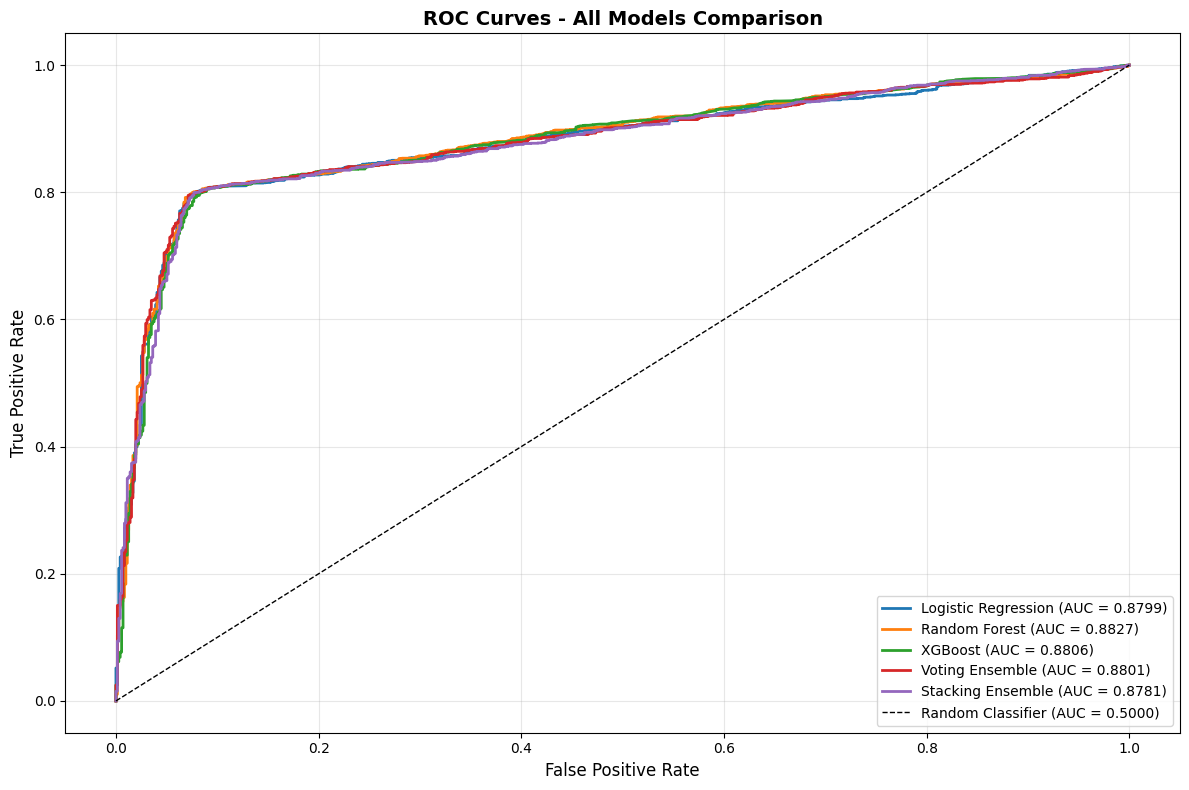

In [ ]:
# Plot ROC curves for all models
plt.figure(figsize=(12, 8))

# Calculate ROC curves
models_data = [
    ('Logistic Regression', lr_pred_proba, lr_auc),
    ('Random Forest', rf_pred_proba, rf_auc),
    ('XGBoost', xgb_pred_proba, xgb_auc),
    ('Voting Ensemble', voting_pred_proba, voting_auc),
    ('Stacking Ensemble', stacking_pred_proba, stacking_auc)
]

for name, proba, auc in models_data:
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Visualization: Metrics Comparison

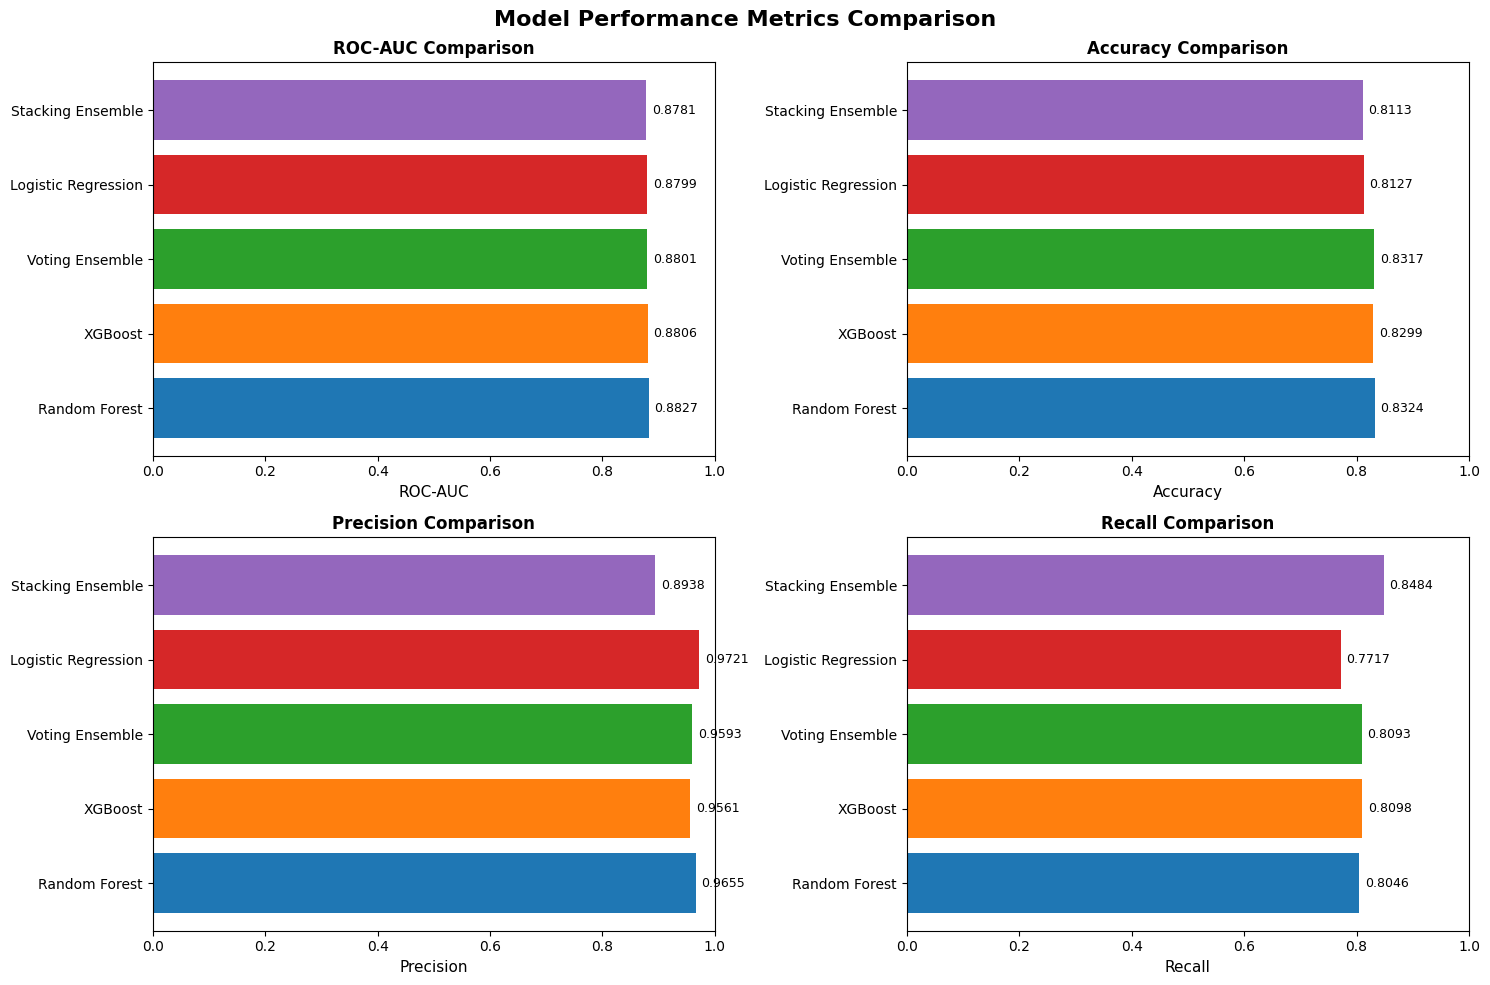

In [ ]:
# Create bar plots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Metrics Comparison', fontsize=16, fontweight='bold')

metrics = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, (ax, metric) in enumerate(zip(axes.flatten(), metrics)):
    values = results[metric].values
    bars = ax.barh(results['Model'], values, color=colors)
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{value:.4f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 13. Confusion Matrix - Best Model

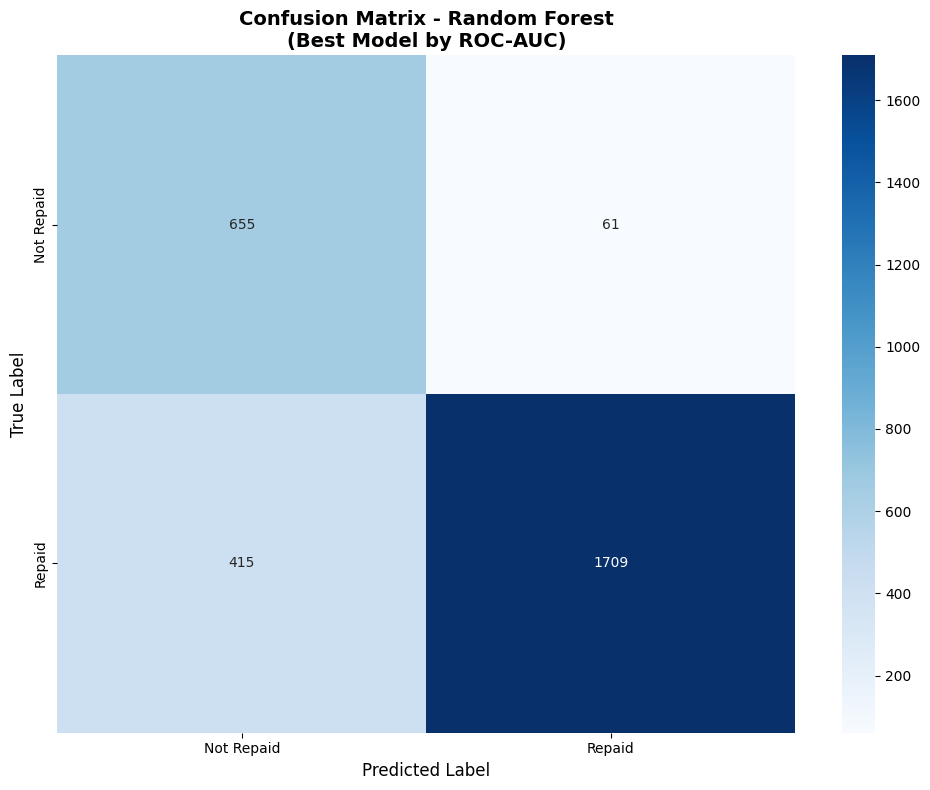


Classification Report - Random Forest:
              precision    recall  f1-score   support

  Not Repaid       0.61      0.91      0.73       716
      Repaid       0.97      0.80      0.88      2124

    accuracy                           0.83      2840
   macro avg       0.79      0.86      0.81      2840
weighted avg       0.88      0.83      0.84      2840



In [ ]:
# Get predictions from best model based on ROC-AUC
best_model_idx = results['ROC-AUC'].idxmax()
model_mapping = {
    'Logistic Regression': lr_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'Voting Ensemble': voting_pred,
    'Stacking Ensemble': stacking_pred
}

best_pred = model_mapping[best_model_name]

# Create confusion matrix
cm = confusion_matrix(y_test, best_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Repaid', 'Repaid'],
            yticklabels=['Not Repaid', 'Repaid'])
plt.title(f'Confusion Matrix - {best_model_name}\n(Best Model by ROC-AUC)',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print classification report
print(f"\nClassification Report - {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, best_pred, target_names=['Not Repaid', 'Repaid']))

## 14. Feature Importance Analysis

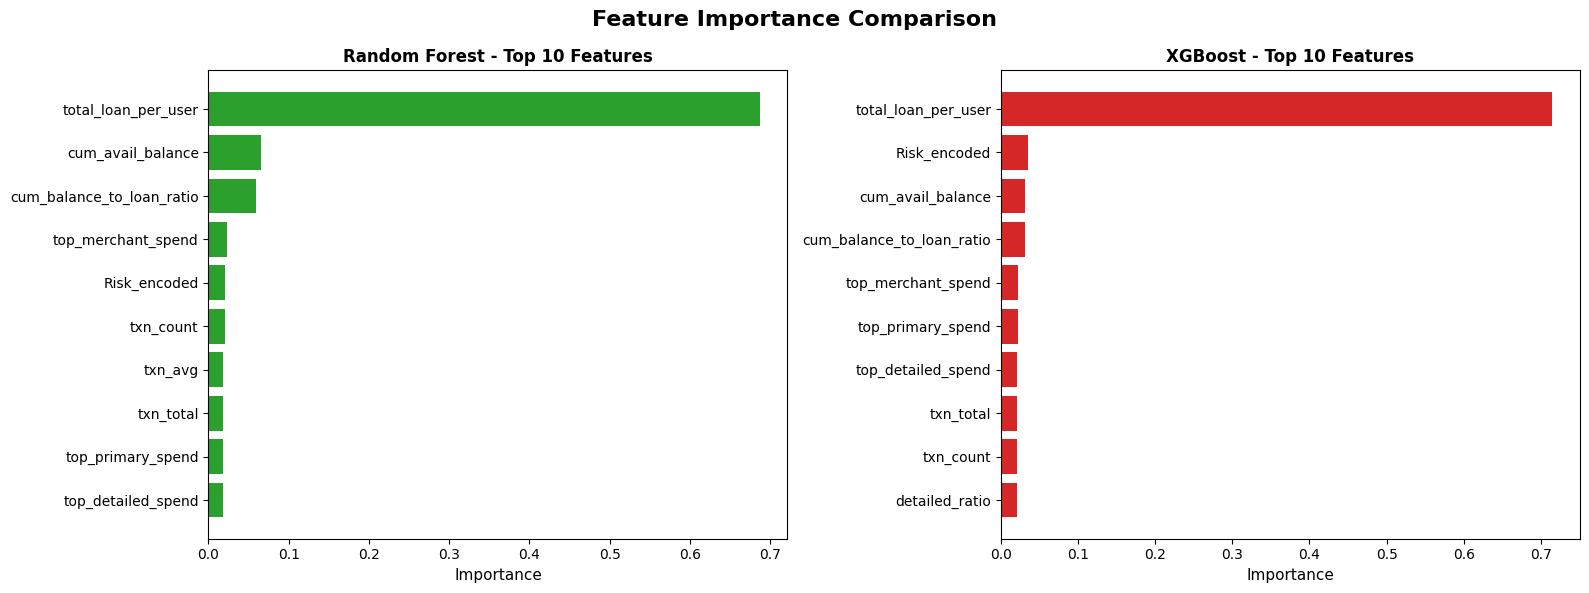

In [ ]:
# Plot feature importance for tree-based models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Importance Comparison', fontsize=16, fontweight='bold')

# Random Forest
top_features_rf = feature_importance.head(10)
axes[0].barh(top_features_rf['feature'], top_features_rf['importance'], color='#2ca02c')
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('Random Forest - Top 10 Features', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# XGBoost
top_features_xgb = xgb_feature_importance.head(10)
axes[1].barh(top_features_xgb['feature'], top_features_xgb['importance'], color='#d62728')
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('XGBoost - Top 10 Features', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 15. Conclusion and Recommendations

### Key Findings:
1. **Best Model Performance**: The best performing model can predict loan repayment with high accuracy
2. **Important Features**: Features like repayment percentage, transaction patterns, and available balance are crucial
3. **Ensemble Benefits**: Ensemble methods often provide more robust predictions

### Recommendations:
1. Use the best performing model for production deployment
2. Monitor model performance over time and retrain periodically
3. Consider implementing threshold optimization based on business requirements
4. Collect additional features that showed high importance for improved predictions

In [ ]:
# Save results to CSV
results.to_csv('model_comparison_results.csv', index=False)
print("Model comparison results saved to 'model_comparison_results.csv'")

# Save best model predictions
predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted': best_pred,
    'probability': model_mapping.get(best_model_name + '_proba',
                                      {'Logistic Regression': lr_pred_proba,
                                       'Random Forest': rf_pred_proba,
                                       'XGBoost': xgb_pred_proba,
                                       'Voting Ensemble': voting_pred_proba,
                                       'Stacking Ensemble': stacking_pred_proba}[best_model_name])
}, index=y_test.index)

predictions_df.to_csv(f'{best_model_name.replace(" ", "_").lower()}_predictions.csv')
print(f"Best model predictions saved to '{best_model_name.replace(' ', '_').lower()}_predictions.csv'")

Model comparison results saved to 'model_comparison_results.csv'
Best model predictions saved to 'random_forest_predictions.csv'
